# Getting and preparing data for colorization

## Setup

First, we install the required libraries.

In [1]:
!pip install -r requirements.txt --quiet

Then, we import all the libraries we will use for the project.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# plotting
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

## Downloading video data

In [5]:
from pytube import YouTube
from video_utils import print_video_summary

In [6]:
video = YouTube('https://www.youtube.com/watch?v=btnFUbexxEE')

In [7]:
print_video_summary(video)

Summary:
Title: Wario Land 3 (GBC) - 100 Treasures Longplay
Duration: 247.28 minutes
Rating: 4.83
# of views: 180952


In [8]:
# display only the streams with the selected file format 
video.streams.filter(file_extension = "mp4").all()

[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d" progressive="False" type="video">,
 <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b" progressive="False" type="video">,
 <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2" progressive="False" type="audio">]

In [9]:
# download the selected video
video.streams.get_by_itag(18).download()

'/Users/eryklewinson/Eryk_private_stuff/video_games_colorization/Wario Land 3 (GBC) - 100 Treasures Longplay.mp4'

## Image preprocessing

### Extracting frames from the video

In [10]:
from video_utils import FrameExtractor
from image_utils import preview_image, preview_lab_image

In [11]:
# instantiate the class using the downloaded video
fe = FrameExtractor('Wario Land 3 (GBC) - 100 Treasures Longplay.mp4')

In [12]:
# print the video's duration
fe.get_video_duration()

Duration: 4:14:38.448276


In [13]:
# calculate the potential number of frames 
fe.get_n_images(every_x_frame=2*fe.fps)

Extracting every 58 (nd/rd/th) frame would result in 7640 images.


In [21]:
fe.extract_frames(every_x_frame=2*fe.fps, 
                  img_name='wario_land_3_img', 
                  dest_path='images/train/wario/')

Created the following directory: images/train/wario/


### Inspecting the images

In [22]:
path = 'images/train/wario/wario_land_3_img_300.jpg'

The size of the image is: (288, 320, 3)


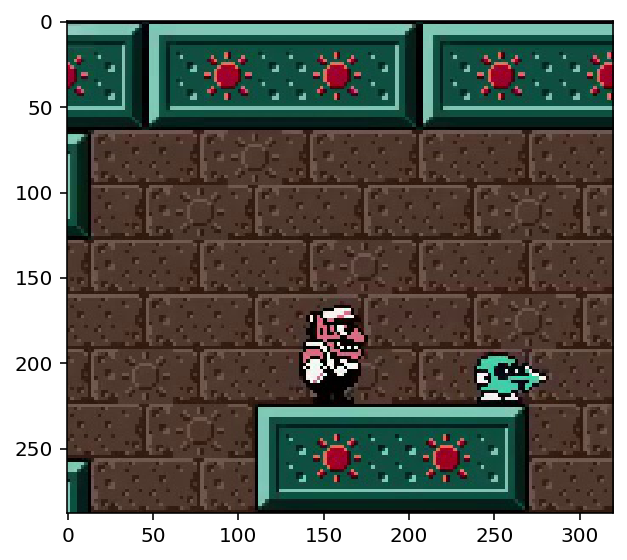

In [23]:
preview_image(path)

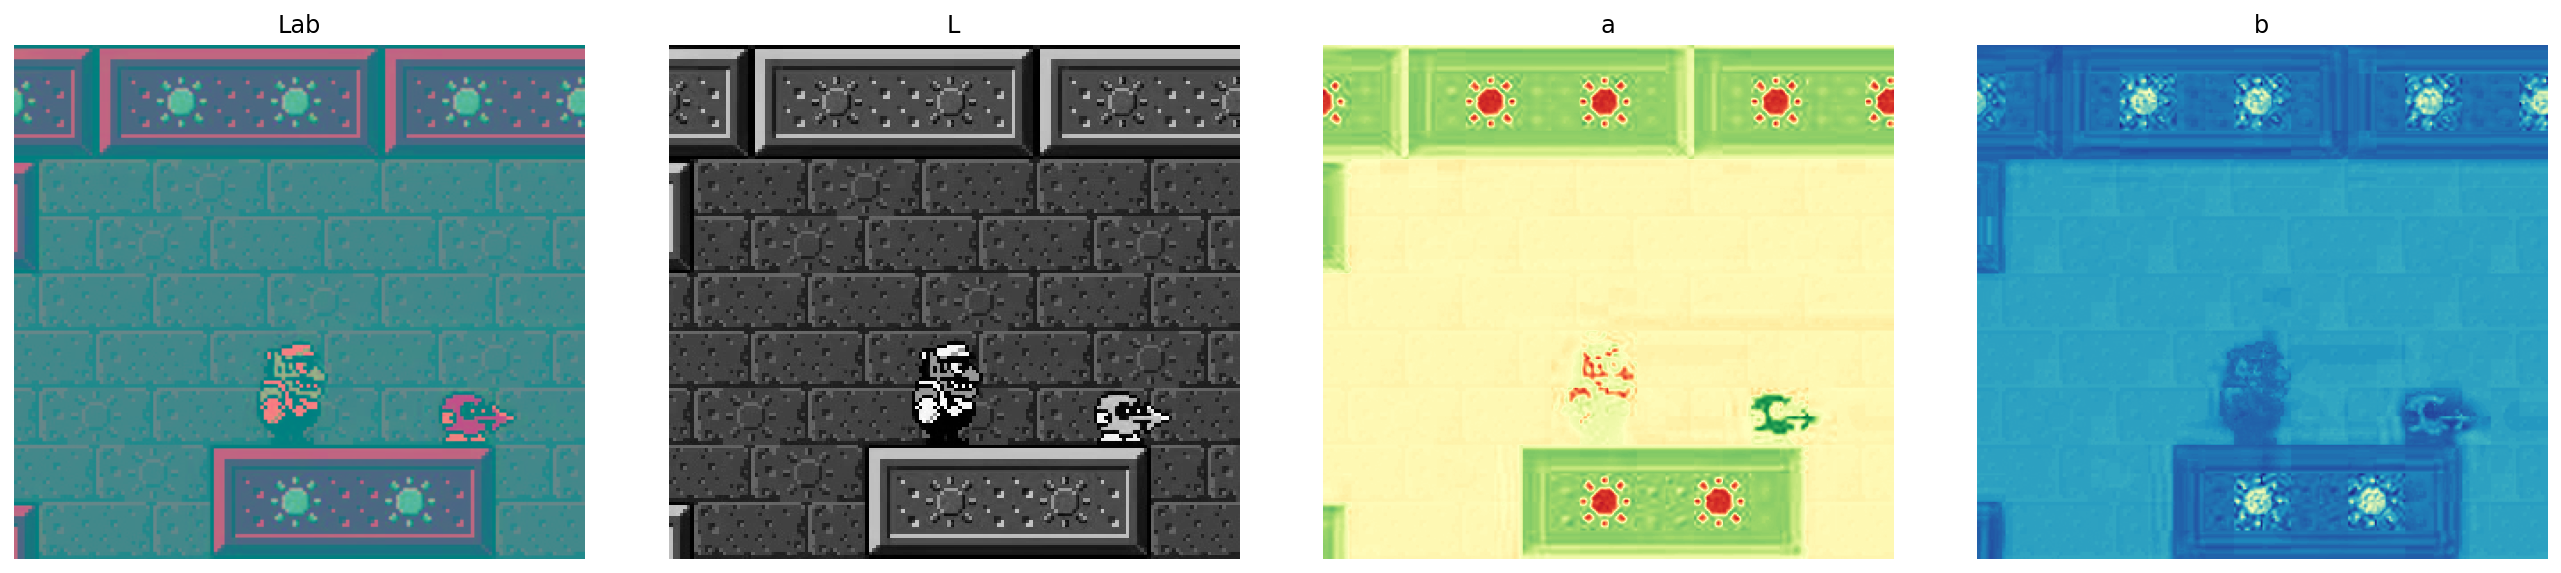

In [24]:
preview_lab_image(path)

### Dividing images into training/test sets

In [26]:
from utils import move_random_files

In [27]:
move_random_files(from_dir='images/train/wario', 
                  to_dir='images/valid/wario', 
                  file_format='jpg', 
                  perc=0.1)

There are 7640 .jpg files in the source directory.
Moving 764 files...
done.


## PyTorch Implementation

### DataLoaders

In [5]:
import numpy as np

import torch 
from torchvision import datasets, transforms

from skimage.color import rgb2lab, lab2rgb
from skimage.io import imshow



In [6]:
BARCH_SIZE = 32 # number of samples to load per batch
IMG_SIZE = 288
NEW_IMG_SIZE = int(IMG_SIZE / 2)

In [7]:
class ColorizationImageFolder(datasets.ImageFolder):
    '''Custom images folder, which converts images to grayscale before loading'''
    
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            
            # convert to lab
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + [0, 0, 0]) / [100, 128, 128] # for tanh activation in the last layer 
            #img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255] # as in my article
            #img_lab = (img_lab + 128) / 255
            
            img_ab = img_lab[:,:,1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            
            img_gray = img_lab[:,:,0]
            img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
                    
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img_gray, img_ab, target

In [8]:
# define transformations
train_transforms = transforms.Compose([transforms.RandomCrop(IMG_SIZE),
                                       transforms.Resize(NEW_IMG_SIZE)])

valid_transforms = transforms.Compose([transforms.Resize((NEW_IMG_SIZE, NEW_IMG_SIZE))])

In [9]:
# image folders
train_folder = ColorizationImageFolder('images/train', train_transforms)
valid_folder = ColorizationImageFolder('images/valid' , valid_transforms)

In [10]:
# Validation 
train_loader = torch.utils.data.DataLoader(train_folder, batch_size=BARCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_folder, batch_size=BARCH_SIZE, shuffle=False)

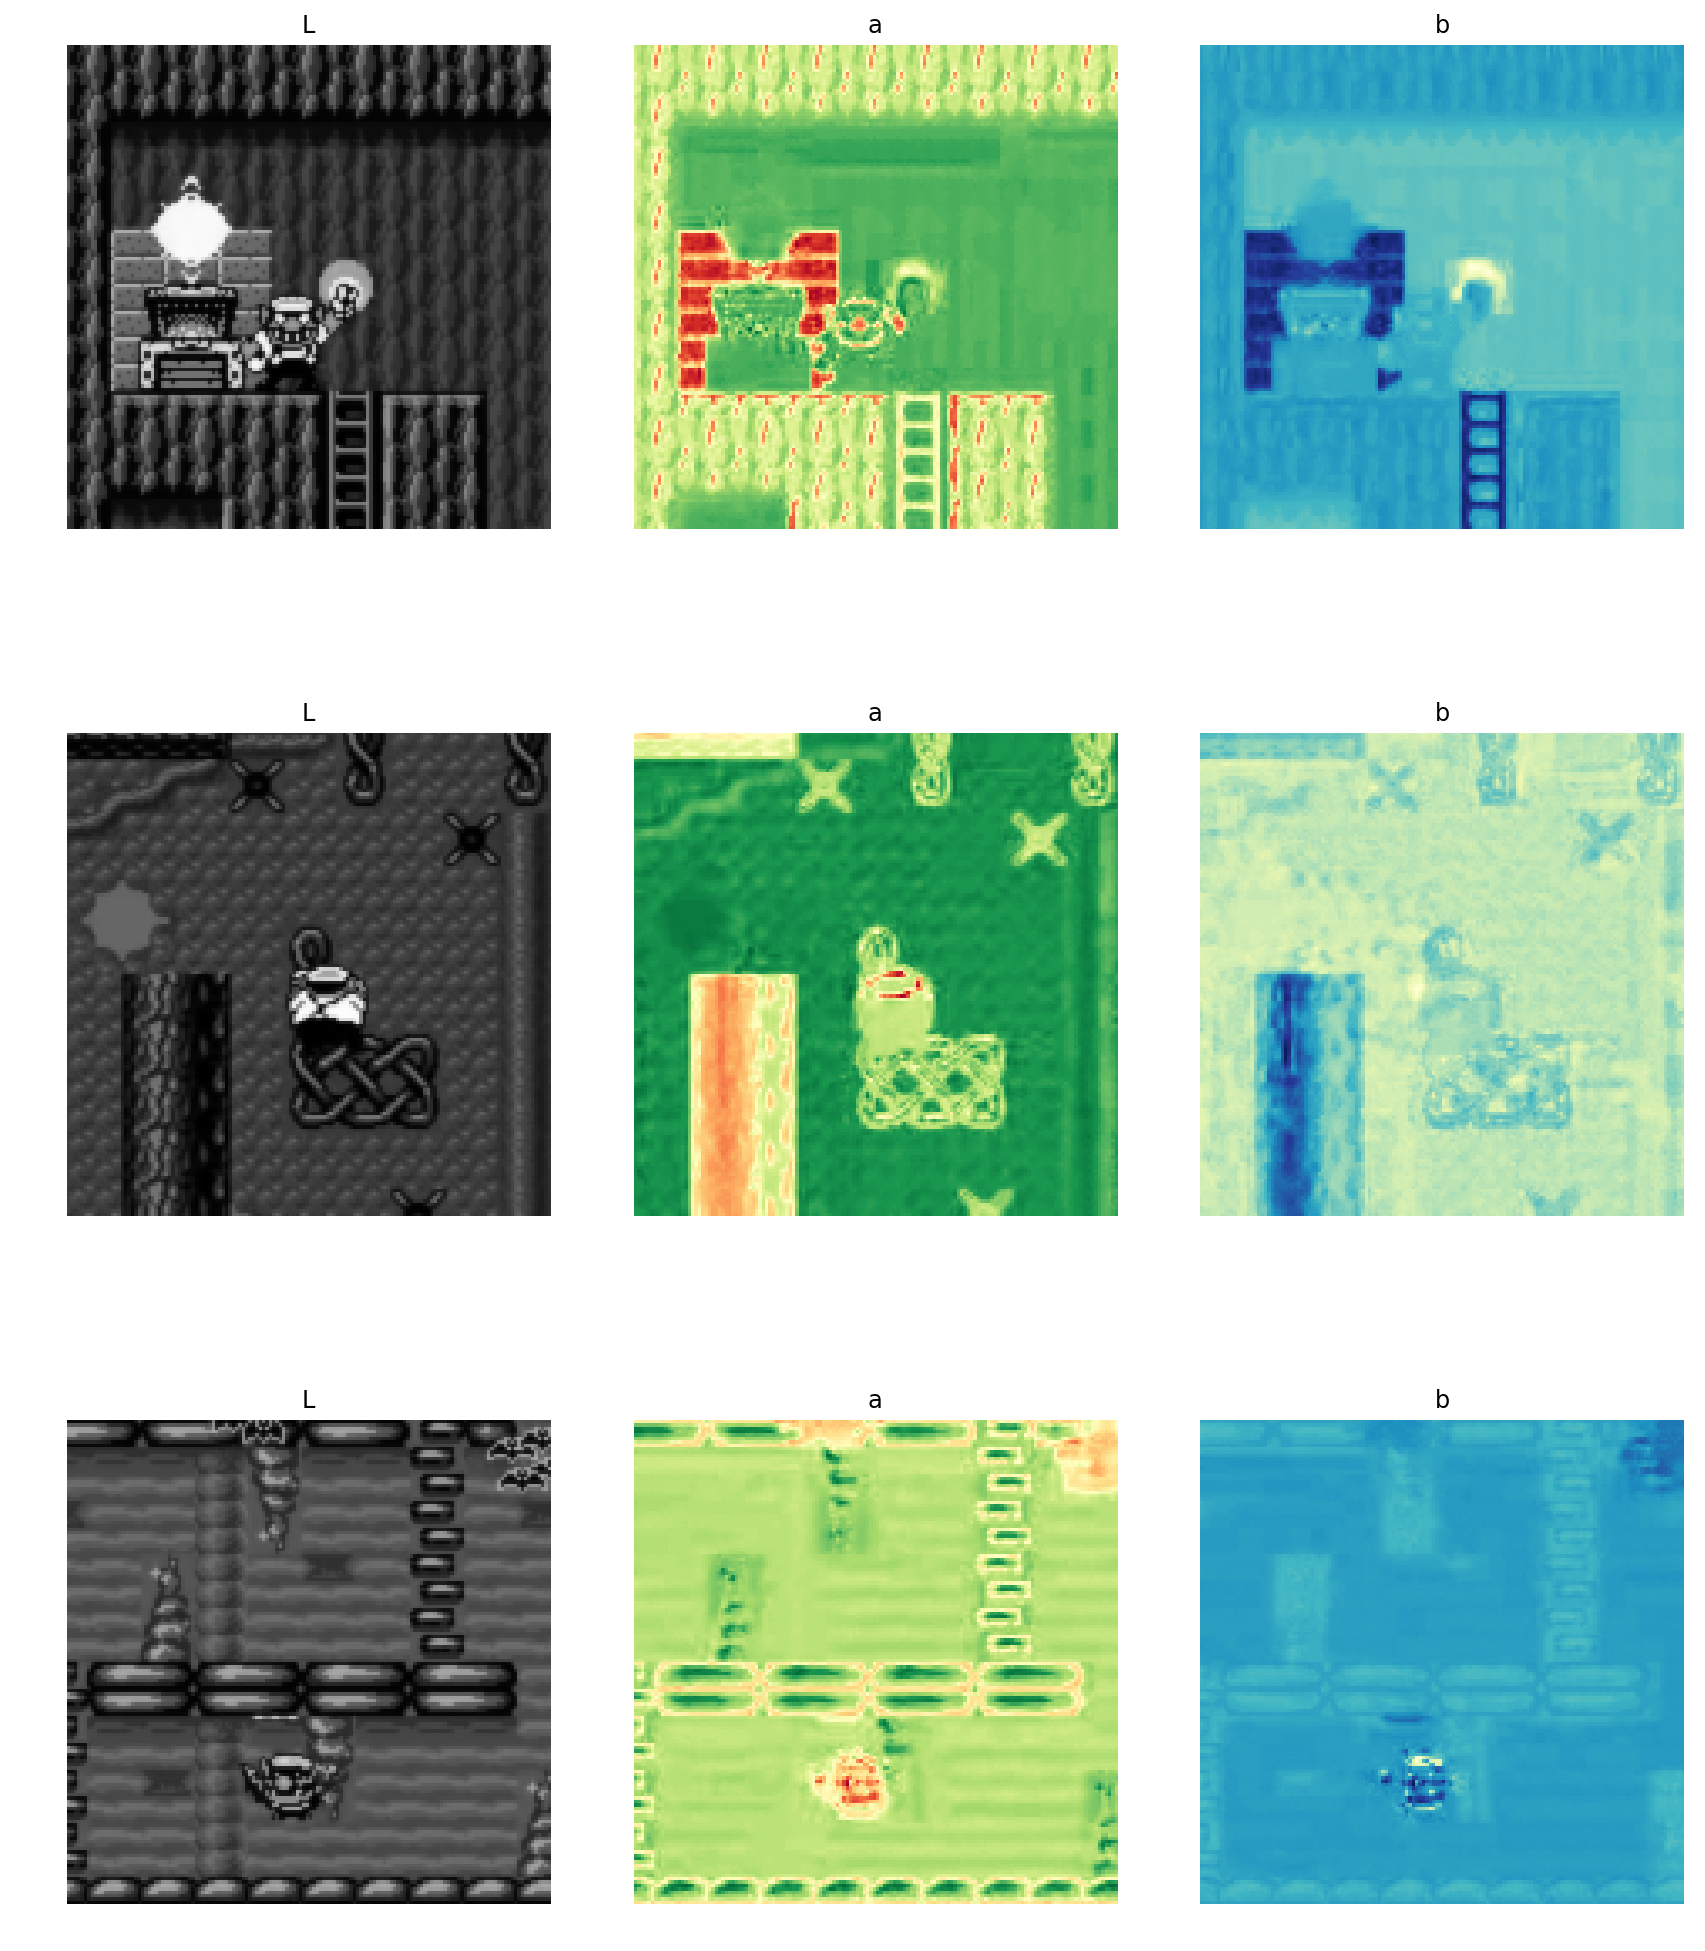

In [11]:
# obtain one batch of training images
data_iter = iter(train_loader)
img_gray, img_ab, target = data_iter.next()

# preview first 3 images in the batch
fig, ax = plt.subplots(3, 3, figsize = (12, 15))

for i in range(0, 3):
    imshow(img_gray[i][0].numpy(), ax=ax[i][0]) 
    ax[i][0].axis('off')
    ax[i][0].set_title('L')

    ax[i][1].imshow(img_ab[i][0].numpy(), cmap='RdYlGn_r') 
    ax[i][1].axis('off')
    ax[i][1].set_title('a')

    ax[i][2].imshow(img_ab[i][1].numpy(), cmap='YlGnBu_r') 
    ax[i][2].axis('off')
    ax[i][2].set_title('b');

### Model

In [12]:
# For everything
import torch.nn as nn
import os, time
from datetime import datetime 
from dl_utils import AverageMeter, custom_set_seed, plot_losses
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
custom_set_seed(42)

In [14]:
# Make folders
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

In [15]:
class Upsample(nn.Module):
    def __init__(self, scale_factor, mode):
        super(Upsample, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

In [16]:
class ColorCNN(nn.Module):
    def __init__(self):
        super(ColorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.upsampling = Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv8 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)

        self.color = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.upsampling,
            self.conv7,
            self.relu,
            self.upsampling,
            self.conv8,
            self.relu,
            self.upsampling,
            self.conv9,
            self.tanh
        )
    
    def forward(self, x):
        return self.color(x)

In [17]:
model = ColorCNN().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

In [18]:
model

ColorCNN(
  (relu): ReLU()
  (tanh): Tanh()
  (upsampling): Upsample()
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (color): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3)

In [19]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    running_loss = 0
    
    for i, (input_gray, input_ab, target) in enumerate(train_loader):

        optimizer.zero_grad()
        
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)
    
        # Forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        running_loss += loss.item() * input_gray.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [20]:
# def train(train_loader, model, criterion, optimizer, epoch, device):
#     print(f'Starting training epoch {epoch}')
#     model.train()

#     # Prepare value counters and timers
#     batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

#     end = time.time()
#     for i, (input_gray, input_ab, target) in enumerate(train_loader):

#         input_gray = input_gray.to(device)
#         input_ab = input_ab.to(device)
#         target = target.to(device)

#         # Record time to load data (above)
#         data_time.update(time.time() - end)

#         # Run forward pass
#         output_ab = model(input_gray) 
#         loss = criterion(output_ab, input_ab) 
#         losses.update(loss.item(), input_gray.size(0))

#         # Compute gradient and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Record time to do forward and backward passes
#         batch_time.update(time.time() - end)
#         end = time.time()

#         # Print model accuracy -- in the code below, val refers to value, not validation
#         if i % 25 == 0:
#             print('Epoch: [{0}][{1}/{2}]\t'
#                   'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                   'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
#                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
#                    epoch, i, len(train_loader), batch_time=batch_time,
#                    data_time=data_time, loss=losses)) 

#     print(f'Finished training epoch {epoch}')

In [21]:
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''
    Show/save rgb image from grayscale and ab channels
    Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}
    '''
    
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 128 ###255 - 128    # as in my article
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [22]:
def validate(valid_loader, model, criterion, save_images, epoch, device):
    model.eval()
    running_loss = 0
    already_saved_images = False
    
    for i, (input_gray, input_ab, target) in enumerate(valid_loader):
    
        input_gray = input_gray.to(device)
        input_ab = input_ab.to(device)

        # Forward pass and record loss
        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        running_loss += loss.item() * input_gray.size(0)

        # Save images to file
        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(min(len(output_ab), 2)): # save at most 2 images
                save_path = {'grayscale': 'outputs/gray/', 
                             'colorized': 'outputs/color/'}
                save_name = f'img-{i * valid_loader.batch_size + j}-epoch-{epoch}.jpg'
                to_rgb(input_gray[j].cpu(), 
                       ab_input=output_ab[j].detach().cpu(), 
                       save_path=save_path, 
                       save_name=save_name)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return epoch_loss

In [23]:
# def validate(val_loader, model, criterion, save_images, epoch, device):
#     model.eval()

#     # Prepare value counters and timers
#     batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

#     end = time.time()
#     already_saved_images = False
#     for i, (input_gray, input_ab, target) in enumerate(val_loader):
#         data_time.update(time.time() - end)

#         input_gray = input_gray.to(device)
#         input_ab = input_ab.to(device)
#         target = target.to(device)

#         # Run model and record loss
#         output_ab = model(input_gray) # throw away class predictions
#         loss = criterion(output_ab, input_ab)
#         losses.update(loss.item(), input_gray.size(0))

#         # Save images to file
#         if save_images and not already_saved_images:
#             already_saved_images = True
#             for j in range(min(len(output_ab), 10)): # save at most 5 images
#                 save_path = {'grayscale': 'outputs/gray/', 
#                              'colorized': 'outputs/color/'}
#                 save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
#                 to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), 
#                        save_path=save_path, save_name=save_name)

#         # Record time to do forward passes and save images
#         batch_time.update(time.time() - end)
#         end = time.time()

#         # Print model accuracy -- in the code below, val refers to both value and validation
#         if i % 25 == 0:
#             print('Validate: [{0}/{1}]\t'
#                 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                 'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
#                  i, len(val_loader), batch_time=batch_time, loss=losses))

#     print('Finished validation.')
#     return losses.avg

In [24]:
# set parameters
save_images = True
best_loss = 1e10
epochs = 10
print_every = 1

# set objects for storing metrics
train_losses = []
valid_losses = []
time_meter = AverageMeter()

# Train model
for epoch in range(1, epochs+1):
    
    start_time = time.time()
    
    # training
    train_loss = train(train_loader, model, criterion, optimizer, epoch, device)
    train_losses.append(train_loss)
    
    # validation
    with torch.no_grad():
        valid_loss = validate(valid_loader, model, criterion, save_images, epoch, device)
        valid_losses.append(valid_loss)
    
    # Save checkpoint and replace old best model if current model is better
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), f'checkpoints/model-epoch-{epoch+1}-losses-{valid_loss:.3f}.pth')
        
    end_time = time.time()
    epoch_time = end_time - start_time
    time_meter.update(epoch_time)
        
    if epoch % print_every == 0:
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Epoch time: {epoch_time:.2f} (avg. {time_meter.avg:.2f})')

22:22:46 --- Epoch: 1	Train loss: 0.0188	Valid loss: 0.0192	Epoch time: 164.13 (avg. 164.13)
22:26:44 --- Epoch: 2	Train loss: 0.0185	Valid loss: 0.0191	Epoch time: 238.11 (avg. 201.12)
22:38:21 --- Epoch: 3	Train loss: 0.0184	Valid loss: 0.0191	Epoch time: 696.29 (avg. 366.18)
22:50:07 --- Epoch: 4	Train loss: 0.0185	Valid loss: 0.0190	Epoch time: 706.86 (avg. 451.35)
23:00:21 --- Epoch: 5	Train loss: 0.0185	Valid loss: 0.0190	Epoch time: 613.72 (avg. 483.82)
23:10:35 --- Epoch: 6	Train loss: 0.0185	Valid loss: 0.0190	Epoch time: 613.63 (avg. 505.46)
23:21:47 --- Epoch: 7	Train loss: 0.0185	Valid loss: 0.0190	Epoch time: 672.55 (avg. 529.33)
23:33:40 --- Epoch: 8	Train loss: 0.0185	Valid loss: 0.0191	Epoch time: 712.24 (avg. 552.19)
23:45:05 --- Epoch: 9	Train loss: 0.0185	Valid loss: 0.0190	Epoch time: 685.69 (avg. 567.02)
23:55:20 --- Epoch: 10	Train loss: 0.0185	Valid loss: 0.0190	Epoch time: 614.30 (avg. 571.75)


<Figure size 432x288 with 0 Axes>

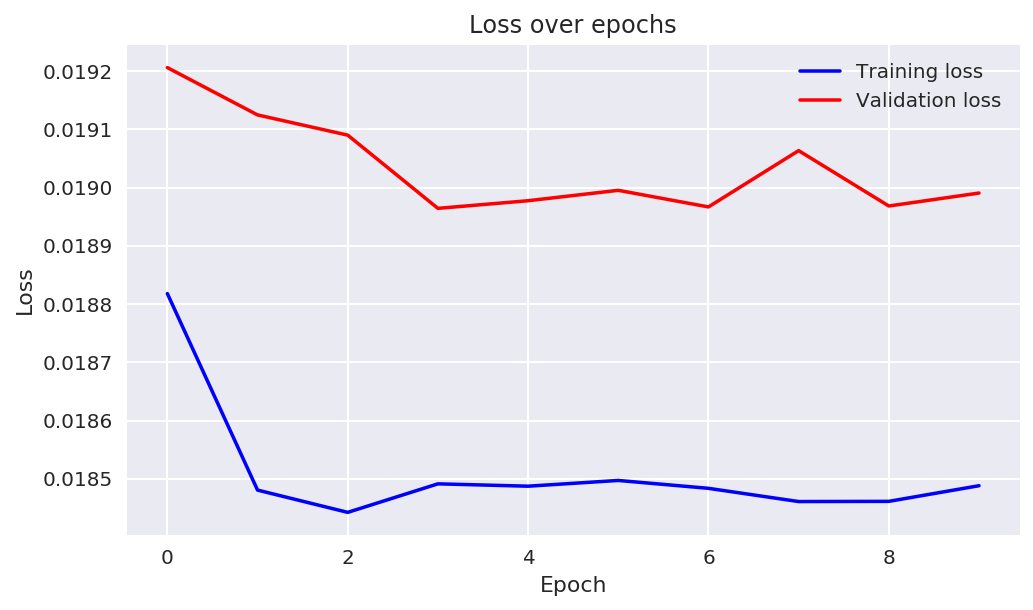

In [25]:
plot_losses(train_losses, valid_losses)

### Manual Evaluation

In [76]:
from image_utils import preview_image, preview_lab_image
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import resize

In [87]:
path = 'images/train/wario/wario_land_3_img_100.jpg'

In [88]:
def show_model_results(path, model, img_size):
    
    test_image = imread(path)
    test_image = resize(test_image, (img_size, img_size))
    test_image_gray = rgb2gray(test_image)
    
    gray_tensor = torch.from_numpy(test_image_gray).unsqueeze(0).unsqueeze(0).float()
    with torch.no_grad():
        ab_tensor = model(gray_tensor)
        
    result = torch.cat((gray_tensor[0], ab_tensor[0]), 0).numpy() 
    result = result.transpose((1, 2, 0))  
    result[:, :, 0:1] = result[:, :, 0:1] * 100
    result[:, :, 1:3] = result[:, :, 1:3] * 128 #255 - 128   
    result = lab2rgb(result.astype(np.float64))
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 15))

    imshow(test_image, ax=ax[0]) 
    ax[0].axis('off')
    ax[0].set_title('RGB')

    imshow(test_image_gray, ax=ax[1])
    ax[1].axis('off')
    ax[1].set_title('Grayscale')

    imshow(result, ax=ax[2])
    ax[2].axis('off')
    ax[2].set_title('ColorNet')

    fig.show()

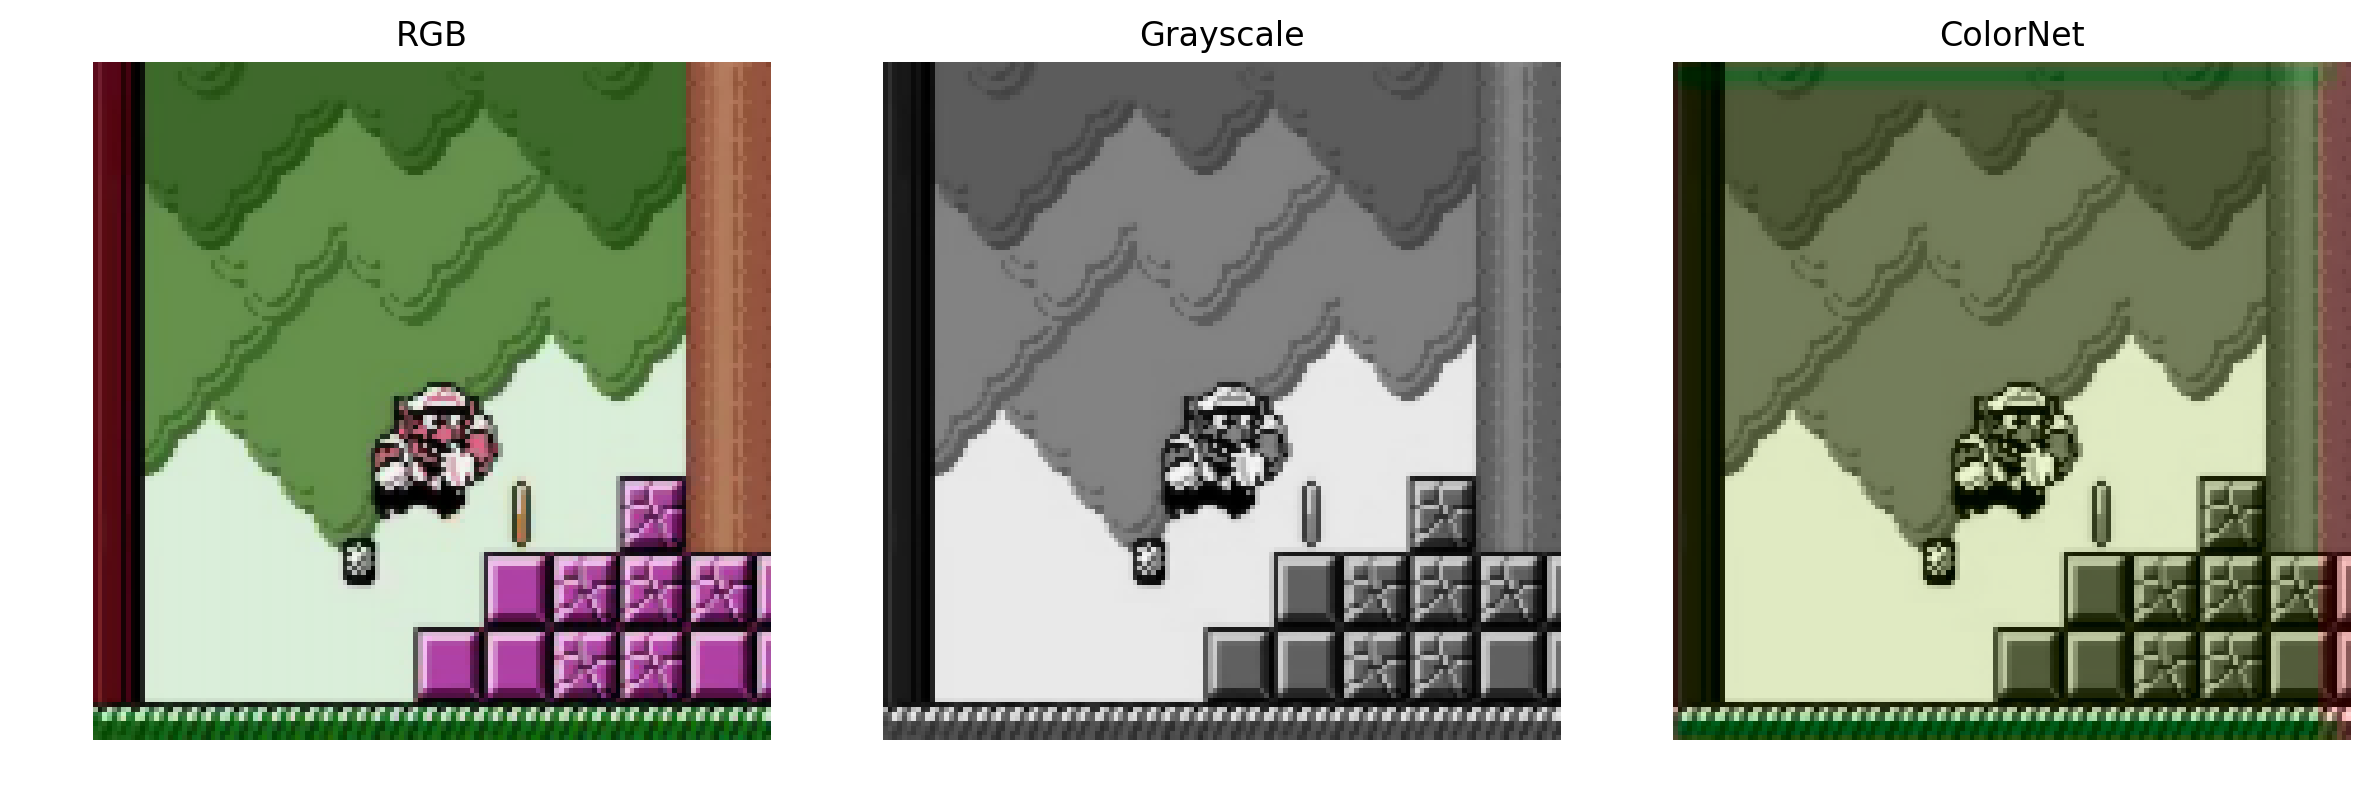

In [89]:
show_model_results(path, model, NEW_IMG_SIZE)

In [ ]:
1